In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

RANDOM_SEED = 42

## Import Data

In [2]:
from sklearn.utils import shuffle

mcu = pd.read_csv("./data/mcu.csv")

min_line_count = 150

is_main_character = mcu["character"].value_counts() > min_line_count
is_main_character = is_main_character.rename("is main character", axis=0)

main_character_rows = is_main_character[mcu["character"]]
main_character_rows = main_character_rows.reset_index(drop=True)

mcu = mcu[main_character_rows]

y = mcu["character"].to_numpy().astype(str)
X = mcu["line"].to_numpy().astype(str)

X, y = shuffle(X, y, random_state=RANDOM_SEED)

X, y

(array(['Got it.', 'And terrifying.', 'What’s the delta rate?', ...,
        'I’m sorry. He seemed like a good man.', 'Heimdall, come on.',
        'I am a king!'], dtype='<U606'),
 array(['BRUCE BANNER', 'PEPPER POTTS', 'TONY STARK', ..., 'STEVE ROGERS',
        'THOR', 'LOKI'], dtype='<U12'))

## Models

In [3]:
from sklearn.pipeline import Pipeline

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB

from sklearn import metrics

import matplotlib.pyplot as plt

In [4]:
cross_validator = StratifiedKFold(n_splits=5, random_state=RANDOM_SEED, shuffle=True)
score_method = "balanced_accuracy"

Let's create two models: one that uses a TFIDF transformer and one that does not. 

### Model 1 (without TDIDF)

In [5]:
pipe1 = Pipeline([('vect', CountVectorizer()), 
                  ('clf', MultinomialNB())])

parameters1 = {'vect__binary': [True, False],
              'vect__stop_words': [None, 'english'],
              'vect__ngram_range': [(1,1), (1,2), (1,3)],
              'clf__alpha': [10, 1, 1e-1, 1e-2, 1e-3, 1e-4],
              'clf__fit_prior': [True, False]}

grid1 = GridSearchCV(pipe1, parameters1, cv=cross_validator, scoring=score_method, n_jobs=-1, verbose=3)

grid1.fit(X,y)

grid1.best_params_

Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 488 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed:   11.2s finished


{'clf__alpha': 0.1,
 'clf__fit_prior': False,
 'vect__binary': False,
 'vect__ngram_range': (1, 3),
 'vect__stop_words': None}

In [19]:
model1 = Pipeline([('vect', CountVectorizer(binary=False, ngram_range=(1,3), stop_words=None)), 
                  ('clf', MultinomialNB(alpha=0.1, fit_prior=False))])

### Model 2 (with TDIDF)

In [7]:
pipe2 = Pipeline([('vect', CountVectorizer()),
                  ('tfidf', TfidfTransformer()),
                  ('clf', MultinomialNB())])

parameters2 = {'vect__binary': [True, False],
              'vect__stop_words': [None, 'english'],
              'vect__ngram_range': [(1,1), (1,2), (1,3)],
              'tfidf__norm': ['l1', 'l2'],
              'tfidf__use_idf': [True, False],
              'tfidf__smooth_idf': [True, False],
              'tfidf__sublinear_tf': [True, False],
              'clf__alpha': [10, 1, 1e-1, 1e-2, 1e-3, 1e-4],
              'clf__fit_prior': [True, False]}

grid2 = GridSearchCV(pipe2, parameters2, cv=cross_validator, scoring=score_method, n_jobs=-1, verbose=3)

grid2.fit(X,y)

grid2.best_params_

Fitting 5 folds for each of 2304 candidates, totalling 11520 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done 952 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done 1528 tasks      | elapsed:   22.6s
[Parallel(n_jobs=-1)]: Done 2232 tasks      | elapsed:   31.9s
[Parallel(n_jobs=-1)]: Done 3064 tasks      | elapsed:   43.0s
[Parallel(n_jobs=-1)]: Done 4024 tasks      | elapsed:   56.3s
[Parallel(n_jobs=-1)]: Done 5112 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 6328 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 7672 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 9144 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 10744 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 11520 out of 11520 | elapsed:  2.7min finished


{'clf__alpha': 0.01,
 'clf__fit_prior': False,
 'tfidf__norm': 'l2',
 'tfidf__smooth_idf': True,
 'tfidf__sublinear_tf': True,
 'tfidf__use_idf': False,
 'vect__binary': False,
 'vect__ngram_range': (1, 2),
 'vect__stop_words': None}

In [20]:
model2 = Pipeline([('vect', CountVectorizer(binary=False, ngram_range=(1,2), stop_words=None)),
                  ('tfidf', TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=True, use_idf=False)),
                  ('clf', MultinomialNB(alpha=0.01, fit_prior=False))])

### Model 3 (Stemming, better stop words, no TFIDF)

In [18]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

class StemCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(StemCountVectorizer, self).build_analyzer()
        
        return lambda document: ([SnowballStemmer('english', ignore_stopwords=True).stem(word) for word in analyzer(document)])
    
    
vectorizer = StemCountVectorizer()
vectorizer.fit_transform(X)
print(vectorizer.get_feature_names())

['04', '07', '100', '11', '119', '12', '14', '16s', '1825', '19', '1943', '20', '22', '229', '2300', '30', '3000', '39th', '48', '49', '50', '5000', '5484', '5s', '60', '64', '70', '7043', '76', '800', '80th', '90s', 'aaand', 'aaarrrgh', 'aah', 'aakonian', 'aaskvarian', 'abandon', 'abduct', 'abil', 'abl', 'aboard', 'about', 'above', 'absolut', 'abu', 'abyss', 'accept', 'access', 'accid', 'account', 'accur', 'acetelyen', 'achiev', 'acm', 'acquir', 'across', 'act', 'activ', 'actor', 'actress', 'actual', 'add', 'admir', 'admit', 'adopt', 'adrift', 'adult', 'advanc', 'adventur', 'aero', 'aether', 'afford', 'afield', 'afraid', 'after', 'again', 'against', 'age', 'agent', 'ago', 'agre', 'agreement', 'ah', 'ahead', 'ahh', 'aim', 'ain', 'air', 'alarm', 'alcohol', 'ale', 'algorithm', 'alibi', 'alien', 'alik', 'aliv', 'all', 'alley', 'alli', 'allow', 'alloy', 'almost', 'alon', 'along', 'alreadi', 'alright', 'also', 'altern', 'altitud', 'altruism', 'alway', 'am', 'amaz', 'amen', 'america', 'ameri

In [10]:
pipe3 = Pipeline([('vect', StemCountVectorizer()), 
                  ('clf', MultinomialNB())])

parameters3 = {'vect__binary': [True, False],
               'vect__stop_words': [None, 'english', stopwords.words('english')],
              'vect__ngram_range': [(1,1), (1,2), (1,3)],
              'clf__alpha': [10, 1, 1e-1, 1e-2, 1e-3, 1e-4],
              'clf__fit_prior': [True, False]}

grid3 = GridSearchCV(pipe3, parameters3, cv=cross_validator, scoring=score_method, n_jobs=-1, verbose=3)

grid3.fit(X,y)

grid3.best_params_

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   19.8s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:  8.8min
[Parallel(n_jobs=-1)]: Done 488 tasks      | elapsed: 16.0min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed: 26.1min
[Parallel(n_jobs=-1)]: Done 1080 out of 1080 | elapsed: 37.0min finished


{'clf__alpha': 0.1,
 'clf__fit_prior': False,
 'vect__binary': False,
 'vect__ngram_range': (1, 1),
 'vect__stop_words': None}

In [21]:
model3 = Pipeline([('vect', StemCountVectorizer(binary=False, ngram_range=(1,1), stop_words=None)), 
                  ('clf', MultinomialNB(alpha=0.1, fit_prior=False))])

### Model 4 (Stemming, better stop words, with TFIDF)

In [28]:
pipe4 = Pipeline([('vect', StemCountVectorizer()),
                  ('tfidf', TfidfTransformer()),
                  ('clf', MultinomialNB())])

parameters4 = {'vect__binary': [True, False],
               'vect__stop_words': [None, 'english', stopwords.words('english')],
              'vect__ngram_range': [(1,1), (1,2), (1,3)],
              'tfidf__norm': ['l1', 'l2'],
              'tfidf__use_idf': [True, False],
              'clf__alpha': [10, 1, 1e-1, 1e-2, 1e-3, 1e-4],
              'clf__fit_prior': [True, False]}

grid4 = GridSearchCV(pipe4, parameters4, cv=cross_validator, scoring=score_method, n_jobs=-1, verbose=3)

grid4.fit(X,y)

grid4.best_params_

Fitting 5 folds for each of 864 candidates, totalling 4320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   20.8s


KeyboardInterrupt: 

In [ ]:
model4 = 

# Results

In [22]:
results1 = cross_val_score(model1, X, y, cv=cross_validator, scoring=score_method, n_jobs=-1)
results2 = cross_val_score(model2, X, y, cv=cross_validator, scoring=score_method, n_jobs=-1)
results3 = cross_val_score(model3, X, y, cv=cross_validator, scoring=score_method, n_jobs=-1)
results4 = cross_val_score(model4, X, y, cv=cross_validator, scoring=score_method, n_jobs=-1)

table = pd.DataFrame({"model 1": results1, "model 2": results2, "model 3": results3, "model 4": results4})
table.index.name = "fold"
table.loc["mean"] = table.mean()
table.loc["std"] = table.std()
table.loc["max"] = table.max()

table

,model 1,model 2,model 3
fold,,,
0,0.279091,0.292272,0.279967
1,0.243664,0.246281,0.267587
2,0.249391,0.247448,0.260520
3,0.254287,0.273953,0.290900
4,0.269068,0.279468,0.234098
mean,0.259100,0.267884,0.266614
std,0.013074,0.018167,0.019306
max,0.279091,0.292272,0.290900


Looks like model 3 performed better on average.  Let's see it's confusion matrix on a random train / test split of the data in case there are any obvious patterns.

balanced_accuracy: 0.275393076972253


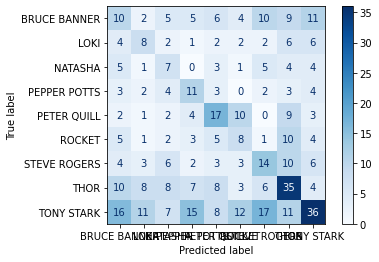

In [23]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

model3.fit(X_train,y_train)
yhat = model3.predict(X_test)

print("balanced_accuracy:", metrics.balanced_accuracy_score(y_test, yhat))

plot = metrics.plot_confusion_matrix(model3, X_test, y_test,
                             values_format = 'd',
                             cmap=plt.cm.Blues)

## Learning Curve

Do we have enough training examples?  Let's find out.

In [24]:
def plot_learning_curve(estimator, title, X, y, axes=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    train_sizes, train_scores, test_scores = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes, verbose=3)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot learning curve
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    plt.legend(loc="best")

    return plot

[learning_curve] Training set sizes: [ 206  671 1136 1601 2066]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  25 | elapsed:   19.9s remaining:   42.4s
[Parallel(n_jobs=-1)]: Done  17 out of  25 | elapsed:   34.2s remaining:   16.0s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   45.7s finished


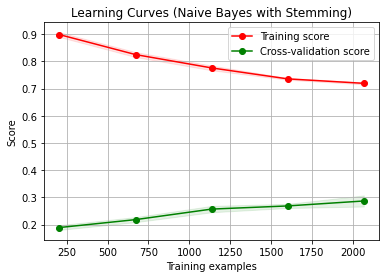

In [25]:
from sklearn.model_selection import learning_curve

title = "Learning Curves (Naive Bayes with Stemming)"

plot_learning_curve(model3, title, X, y, cv=cross_validator)

## Conclusions

It appears to me that these scores in the learning curve have not converged, which suggests that more training examples might yield better performance on this model.  Each character has relatively few words spoken compared to other problems Naive Bayes (NB) might be good at.  For example, Tony Stark only speaks 7600 words in the whole dataset.  Is this too few to train and test on? Also, the balanced accuracy shown in the tables above show very poor performance.  I'm willing to bet this could be because of how little data I have.  However, there is a chance that NB just doesn't work well on this dataset.  In general, movie characters will be discussing similar topics (the plot of the movie), which might make it hard to distinguish character using a bag of words model like NB.

I'm going to try a different model first (most likely SVM or Random Forest), and then, if needed, I'll add more movies to the dataset and retry Naive Bayes.